## 基于波动方程约束的神经网络地震正演模拟

本笔记中展示基于波动方程约束的神经网络地震正演模拟结果，分别对比了物理约束、物理约束采样方式、物理约束采样点数、数据采样空间等因素对神经网络的影响。

In [3]:
import sys
sys.path.insert(0, '../')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from pyDOE import lhs

from Pinns_class import PhysicsInformedNN

def plot_solution(X_star, u_star, index):
    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 256
    x = np.linspace(lb[0], ub[0], nn)
    y = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x,y)
    U_star = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')
    plt.figure(index)
    plt.pcolor(X,Y,U_star, cmap = 'jet')
    plt.colorbar()
    
    
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/4
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

/home/xsq/anaconda3/envs/tf15/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xsq/anaconda3/envs/tf15/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xsq/anaconda3/envs/tf15/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xsq/anaconda3/envs/tf15/lib/python3.6/site-packages/ten

# 全空间无物理约束

In [2]:
if __name__ == "__main__": 


    # N_train points for physics constrain as well as boundary constrain
    N_u_train = 5000
    N_f_train = 10000
    
    # first layer = 3 for (x y t) and the last layer = 1 for (u)
    layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 1]
    
    # Load FD Data
    data = scipy.io.loadmat('./generate_data/weq_300_150.mat')         
    U_star = data['u_star'] # N x T
    T_star = data['t'] # T x 1
    X_star = data['X_star'] # N x 2
    vp_star = data['vp_star'] # N x 1
    N = X_star.shape[0]
    T = T_star.shape[0]
    
    # Rearrange Data 

    XX = np.tile(X_star[:,0:1], (1,T)).T # T x N
    YY = np.tile(X_star[:,1:2], (1,T)).T # T x N
    VP = np.tile(vp_star[:,0:1], (1,T)).T # T x N
    TT = np.tile(T_star[:,0:1], (1,N)) # T x N   
    UU = U_star.T # T x N
    
    x = XX.flatten()[:,None] # NT x 1
    y = YY.flatten()[:,None] # NT x 1
    vp = VP.flatten()[:,None] # NT x 1
    t = TT.flatten()[:,None] # NT x 1
    u = UU.flatten()[:,None] # NT x 1
    
    
    ######################################################################
    ######################## Noiseless Data ##############################
    ######################################################################
    X = np.concatenate([x, y, t], 1)       
    lb = X.min(0)
    ub = X.max(0)

    # Training Data randomly selected from N*T dimensional sapce for training   
    np.random.seed(1234)
    tf.set_random_seed(1234)

    #FD simulation data set
    idx_u = np.random.choice(N*T, N_u_train, replace=False)
    x_u_train = x[idx_u,:]
    y_u_train = y[idx_u,:]
    t_u_train = t[idx_u,:]
    u_train = u[idx_u,:]
    
    # physics constrain from all data set
    X_f_train = lb + (ub-lb)*lhs(3, N_f_train)
    x_f_train = X_f_train[:,0:1]
    y_f_train = X_f_train[:,1:2]
    t_f_train = X_f_train[:,2:3]
    vp_train = 2500
    
    
    # #random select physics constrain
    # idx_f = np.random.choice(N*T, N_f_train, replace=False)  
    # x_f_train = x[idx_f,:]
    # y_f_train = y[idx_f,:]
    # t_f_train = t[idx_f,:]
    # vp_train = vp[idx_f,:]

In [4]:
# Training
niter_bfgs = 10000

train_or_not = 0
history_loss = []

if train_or_not == 1:
    model = PhysicsInformedNN(x_u_train, y_u_train, t_u_train, x_f_train, y_f_train, t_f_train, u_train, vp_train, layers, niter_bfgs)
    # loss_out = model.train(iter=5000, learning_rate=1e-3, batch_num=1, whichloss = 0)
    # history_loss.extend(loss_out)
    # with open('history_loss_adam.txt', 'ab') as f:
    #     np.savetxt(f, history_loss)
    model.train_bfgs(batch_num=1, whichloss = 0)
    
else:   
    model = PhysicsInformedNN(x_u_train, y_u_train, t_u_train, x_f_train, y_f_train, t_f_train, u_train, vp_train, layers, niter_bfgs, ExistModel=1, modelDir='./models/homo/5kdata/NN_1.pickle')

model.save_NN('./models/homo/5kdata/NN_1.pickle')

print('Max time step for u training: %e' % (t_u_train.max()))
print('Max time step for f training: %e' % (t_f_train.max()))

Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Save NN parameters successfully...
Max time step for u training: 2.980000e-01
Max time step for f training: 2.979784e-01


In [5]:
# Test Data at snap = 100 (1-200 time steps) compared with predicted data
snap = np.array([30,60,90,120])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star1 = TT.T[:,snap[0:1]]
u_star1 = U_star[:,snap[0:1]]
t_star2 = TT.T[:,snap[1:2]]
u_star2 = U_star[:,snap[1:2]]
t_star3 = TT.T[:,snap[2:3]]
u_star3 = U_star[:,snap[2:3]]
t_star4 = TT.T[:,snap[3:4]]
u_star4 = U_star[:,snap[3:4]]
    
# Prediction
u_pred1 = model.predict(x_star, y_star, t_star1)
u_pred2 = model.predict(x_star, y_star, t_star2)
u_pred3 = model.predict(x_star, y_star, t_star3)
u_pred4 = model.predict(x_star, y_star, t_star4)
lambda_1_value = model.sess.run(model.lambda_1)

    
# Error
error_u = np.linalg.norm(u_star2-u_pred2,2)/np.linalg.norm(u_star2,2)
error_lambda_1 = np.abs(lambda_1_value - 1.0)*100

print('Error u: %e' % (error_u))     
print('Error l1: %.5f%%' % (error_lambda_1))                             


# Plot Results
#    plot_solution(X_star, u_pred, 1)  
#    plot_solution(X_star, u_star, 2)
#    plot_solution(X_star, u_star - u_pred, 3)

# Predict for plotting
lb = X_star.min(0)
ub = X_star.max(0)
nn = 256
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x,y)
UU1_pred = griddata(X_star, u_pred1.flatten(), (X, Y), method='cubic')
UU2_pred = griddata(X_star, u_pred2.flatten(), (X, Y), method='cubic')
UU3_pred = griddata(X_star, u_pred3.flatten(), (X, Y), method='cubic')
UU4_pred = griddata(X_star, u_pred4.flatten(), (X, Y), method='cubic')
UU1_exact = griddata(X_star, u_star1.flatten(), (X, Y), method='cubic')
UU2_exact = griddata(X_star, u_star2.flatten(), (X, Y), method='cubic')
UU3_exact = griddata(X_star, u_star3.flatten(), (X, Y), method='cubic')
UU4_exact = griddata(X_star, u_star4.flatten(), (X, Y), method='cubic')
UU1_differ = UU1_exact - UU1_pred
UU2_differ = UU2_exact - UU2_pred
UU3_differ = UU3_exact - UU3_pred
UU4_differ = UU4_exact - UU4_pred
VP_exact = griddata(X_star, vp_star.flatten(), (X, Y), method='cubic')

Error u: 1.899921e-01
Error l1: 100.00000%


In [ ]:
#plot adam loss function
#loss_adam = np.loadtxt("history_loss_adma.txt")
#loss_bfgs = np.loadtxt("history_loss_bfgs.txt")

#plt.figure(figsize = (9, 6))
#plt.plot(range(0,loss_adam.shape[0]*10,10), loss_adam, 'orange', label="adam")
#plt.plot(range(0,loss_bfgs.shape[0]*10,10), loss_bfgs, 'blue', label="bfgs")

# plt.yscale('log')
# plt.xlabel('Steps')
# plt.ylabel('Iter times')
# plt.title('Loss')
# plt.legend()
# plt.draw()
# plt.savefig("./figures/loss.png", dpi=600)

## 速度模型与采样点分布

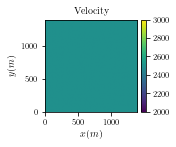

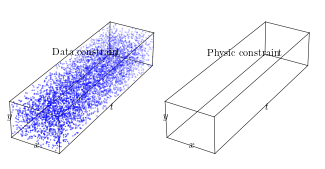

In [6]:
####### Row 0: Velocity ##################    
fig, ax = newfig(1.0, 1.2)
ax.axis('off')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-2/4 + 0.12, left=0.0, right=1.0, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(VP_exact, interpolation='nearest', cmap='viridis', vmin=2000, vmax=3000, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('Velocity', fontsize = 10)
plt.savefig('./figures/homo/5kdata/Velocity.png', dpi = 600)

####### Row 1: Training data ##################
########      data sets     ###################
fig, ax = newfig(1.0, 0.8)
ax.axis('off')

gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=0.9, bottom=0.0, left=0.1, right=0.9, wspace=0.0)

ax = plt.subplot(gs1[:, 0],  projection='3d')
ax.axis('off')
tscale = 17000 # scaling for t axis
yscale = 1
r1 = [x_star.min(), x_star.max()]
r2 = [tscale*data['t'].min(), tscale*data['t'].max()]       
r3 = [yscale*y_star.min(), yscale*y_star.max()]

for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

ax.scatter(x_u_train, tscale*t_u_train, yscale*y_u_train, s = 0.1, c='b')
#ax.contourf(X,UU2_pred,yscale*Y, zdir = 'y', offset = tscale*t_star2.mean(), cmap='seismic', vmin=-3.5, vmax=3.5, alpha = 0.8)
          
ax.text(x_star.mean()-50, tscale*data['t'].min(), yscale*y_star.min() - 100, '$x$')
ax.text(x_star.max(), tscale*data['t'].mean(), yscale*y_star.min() - 120, '$t$')
ax.text(x_star.min()-100, tscale*data['t'].min(), yscale*y_star.mean(), '$y$')
ax.text(x_star.min(), tscale*data['t'].mean()-600, yscale*y_star.max() + 500, 'Data constraint', fontsize=10.0)    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)


########      physic data sets     ###################        
ax = plt.subplot(gs1[:, 1],  projection='3d')
ax.axis('off')
tscale = 17000 # scaling for t axis
yscale = 1
r1 = [x_star.min(), x_star.max()]
r2 = [tscale*data['t'].min(), tscale*data['t'].max()]       
r3 = [yscale*y_star.min(), yscale*y_star.max()]

for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

#ax.scatter(x_f_train, tscale*t_f_train, yscale*y_f_train, s = 0.1, c='r')
#ax.contourf(X,UU2_exact,yscale*Y, zdir = 'y', offset = tscale*t_star2.mean(), cmap='seismic', vmin=-3.5, vmax=3.5, alpha = 0.8)
          
ax.text(x_star.mean()-50, tscale*data['t'].min(), yscale*y_star.min() - 100, '$x$')
ax.text(x_star.max(), tscale*data['t'].mean(), yscale*y_star.min() - 120, '$t$')
ax.text(x_star.min()-100, tscale*data['t'].min(), yscale*y_star.mean(), '$y$')
ax.text(x_star.min(), tscale*data['t'].mean()-600, yscale*y_star.max() + 500, 'Physic constraint', fontsize=10.0)    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)

plt.savefig('./figures/homo/5kdata/Training_sets_position.png', dpi = 600)

## 波场值对比

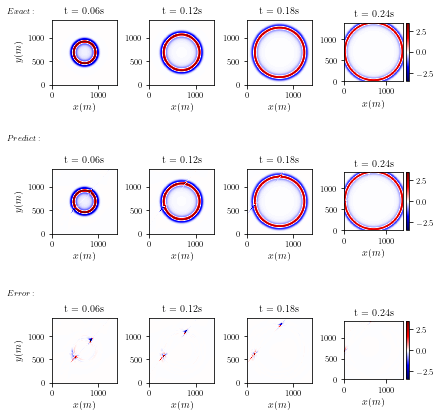

In [7]:
fig, ax = newfig(1.15, 1.7)
ax.axis('off') 
######## Row 2: Pressure #######################
fig.text(0.0, 0.85, '$Exact:$', fontsize = 8)
fig.text(0.0, 0.58, '$Predict:$', fontsize = 8)
fig.text(0.0, 0.25, '$Error:$', fontsize = 8)
########     Exact p(t,x,y)     ########### 
gs2 = gridspec.GridSpec(3, 4)
gs2.update(top=0.9, bottom=0, left=0.1, right=0.9, wspace=0.5, hspace=0.2)

ax = plt.subplot(gs2[0, 0])
h = ax.imshow(UU1_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.06s', fontsize = 10)

ax = plt.subplot(gs2[0, 1])
h = ax.imshow(UU2_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.12s', fontsize = 10)

ax = plt.subplot(gs2[0, 2])
h = ax.imshow(UU3_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.18s', fontsize = 10)

ax = plt.subplot(gs2[0, 3])
h = ax.imshow(UU4_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.24s', fontsize = 10)
########      Predicted p(t,x,y)     ###########

ax = plt.subplot(gs2[1, 0])
h = ax.imshow(UU1_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.06s', fontsize = 10)

ax = plt.subplot(gs2[1, 1])
h = ax.imshow(UU2_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.12s', fontsize = 10)

ax = plt.subplot(gs2[1, 2])
h = ax.imshow(UU3_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.18s', fontsize = 10)

ax = plt.subplot(gs2[1, 3])
h = ax.imshow(UU4_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.24s', fontsize = 10)

#########################Error###############################
ax = plt.subplot(gs2[2, 0])
h = ax.imshow(UU1_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.06s', fontsize = 10)

ax = plt.subplot(gs2[2, 1])
h = ax.imshow(UU2_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.12s', fontsize = 10)

ax = plt.subplot(gs2[2, 2])
h = ax.imshow(UU3_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.18s', fontsize = 10)

ax = plt.subplot(gs2[2, 3])
h = ax.imshow(UU4_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.24s', fontsize = 10)

plt.savefig('./figures/homo/5kdata/weq_comparison.png', dpi = 600)

# 全空间有物理约束

In [4]:
# N_train points for physics constrain as well as boundary constrain
N_u_train = 5000
N_f_train = 10000

# first layer = 3 for (x y t) and the last layer = 1 for (u)
layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# Load FD Data
data = scipy.io.loadmat('./generate_data/weq_300_150.mat')         
U_star = data['u_star'] # N x T
T_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2
vp_star = data['vp_star'] # N x 1
N = X_star.shape[0]
T = T_star.shape[0]

# Rearrange Data 

XX = np.tile(X_star[:,0:1], (1,T)).T # T x N
YY = np.tile(X_star[:,1:2], (1,T)).T # T x N
VP = np.tile(vp_star[:,0:1], (1,T)).T # T x N
TT = np.tile(T_star[:,0:1], (1,N)) # T x N   
UU = U_star.T # T x N

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
vp = VP.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1
u = UU.flatten()[:,None] # NT x 1


######################################################################
######################## Noiseless Data ##############################
######################################################################
X = np.concatenate([x, y, t], 1)       
lb = X.min(0)
ub = X.max(0)

# Training Data randomly selected from N*T dimensional sapce for training   
np.random.seed(1234)
tf.set_random_seed(1234)

#FD simulation data set
idx_u = np.random.choice(N*T, N_u_train, replace=False)
x_u_train = x[idx_u,:]
y_u_train = y[idx_u,:]
t_u_train = t[idx_u,:]
u_train = u[idx_u,:]

# physics constrain from all data set
X_f_train = lb + (ub-lb)*lhs(3, N_f_train)
x_f_train = X_f_train[:,0:1]
y_f_train = X_f_train[:,1:2]
t_f_train = X_f_train[:,2:3]
vp_train = 2500


# #random select physics constrain
# idx_f = np.random.choice(N*T, N_f_train, replace=False)  
# x_f_train = x[idx_f,:]
# y_f_train = y[idx_f,:]
# t_f_train = t[idx_f,:]
# vp_train = vp[idx_f,:]

# Training
niter_bfgs = 10000

train_or_not = 0
history_loss = []

if train_or_not == 1:
    model = PhysicsInformedNN(x_u_train, y_u_train, t_u_train, x_f_train, y_f_train, t_f_train, u_train, vp_train, layers, niter_bfgs)
    # loss_out = model.train(iter=5000, learning_rate=1e-3, batch_num=1, whichloss = 0)
    # history_loss.extend(loss_out)
    # with open('history_loss_adam.txt', 'ab') as f:
    #     np.savetxt(f, history_loss)
    model.train_bfgs(batch_num=1, whichloss = 0)
    
else:   
    model = PhysicsInformedNN(x_u_train, y_u_train, t_u_train, x_f_train, y_f_train, t_f_train, u_train, vp_train, layers, niter_bfgs, ExistModel=1, modelDir='./models/homo/5kdata_1wphy/NN_1.pickle')

model.save_NN('./models/homo/5kdata_1wphy/NN_1.pickle')

print('Max time step for u training: %e' % (t_u_train.max()))
print('Max time step for f training: %e' % (t_f_train.max()))

# Test Data at snap = 100 (1-200 time steps) compared with predicted data
snap = np.array([30,60,90,120])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star1 = TT.T[:,snap[0:1]]
u_star1 = U_star[:,snap[0:1]]
t_star2 = TT.T[:,snap[1:2]]
u_star2 = U_star[:,snap[1:2]]
t_star3 = TT.T[:,snap[2:3]]
u_star3 = U_star[:,snap[2:3]]
t_star4 = TT.T[:,snap[3:4]]
u_star4 = U_star[:,snap[3:4]]
    
# Prediction
u_pred1 = model.predict(x_star, y_star, t_star1)
u_pred2 = model.predict(x_star, y_star, t_star2)
u_pred3 = model.predict(x_star, y_star, t_star3)
u_pred4 = model.predict(x_star, y_star, t_star4)
lambda_1_value = model.sess.run(model.lambda_1)

    
# Error
error_u = np.linalg.norm(u_star2-u_pred2,2)/np.linalg.norm(u_star2,2)
error_lambda_1 = np.abs(lambda_1_value - 1.0)*100

print('Error u: %e' % (error_u))     
print('Error l1: %.5f%%' % (error_lambda_1))                             


# Plot Results
#    plot_solution(X_star, u_pred, 1)  
#    plot_solution(X_star, u_star, 2)
#    plot_solution(X_star, u_star - u_pred, 3)

# Predict for plotting
lb = X_star.min(0)
ub = X_star.max(0)
nn = 256
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x,y)
UU1_pred = griddata(X_star, u_pred1.flatten(), (X, Y), method='cubic')
UU2_pred = griddata(X_star, u_pred2.flatten(), (X, Y), method='cubic')
UU3_pred = griddata(X_star, u_pred3.flatten(), (X, Y), method='cubic')
UU4_pred = griddata(X_star, u_pred4.flatten(), (X, Y), method='cubic')
UU1_exact = griddata(X_star, u_star1.flatten(), (X, Y), method='cubic')
UU2_exact = griddata(X_star, u_star2.flatten(), (X, Y), method='cubic')
UU3_exact = griddata(X_star, u_star3.flatten(), (X, Y), method='cubic')
UU4_exact = griddata(X_star, u_star4.flatten(), (X, Y), method='cubic')
UU1_differ = UU1_exact - UU1_pred
UU2_differ = UU2_exact - UU2_pred
UU3_differ = UU3_exact - UU3_pred
UU4_differ = UU4_exact - UU4_pred
VP_exact = griddata(X_star, vp_star.flatten(), (X, Y), method='cubic')

Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Save NN parameters successfully...
Max time step for u training: 2.980000e-01
Max time step for f training: 2.979784e-01
Error u: 4.247491e-03
Error l1: 100.00000%


## 速度模型与采样点

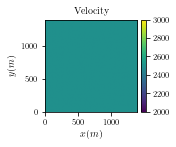

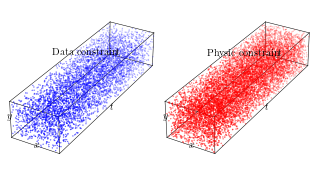

In [5]:
####### Row 0: Velocity ##################    
fig, ax = newfig(1.0, 1.2)
ax.axis('off')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-2/4 + 0.12, left=0.0, right=1.0, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(VP_exact, interpolation='nearest', cmap='viridis', vmin=2000, vmax=3000, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('Velocity', fontsize = 10)
plt.savefig('./figures/homo/5kdata_1wphy/Velocity.png', dpi = 600)

####### Row 1: Training data ##################
########      data sets     ###################
fig, ax = newfig(1.0, 0.8)
ax.axis('off')

gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=0.9, bottom=0.0, left=0.1, right=0.9, wspace=0.0)

ax = plt.subplot(gs1[:, 0],  projection='3d')
ax.axis('off')
tscale = 17000 # scaling for t axis
yscale = 1
r1 = [x_star.min(), x_star.max()]
r2 = [tscale*data['t'].min(), tscale*data['t'].max()]       
r3 = [yscale*y_star.min(), yscale*y_star.max()]

for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

ax.scatter(x_u_train, tscale*t_u_train, yscale*y_u_train, s = 0.1, c='b')
#ax.contourf(X,UU2_pred,yscale*Y, zdir = 'y', offset = tscale*t_star2.mean(), cmap='seismic', vmin=-3.5, vmax=3.5, alpha = 0.8)
          
ax.text(x_star.mean()-50, tscale*data['t'].min(), yscale*y_star.min() - 100, '$x$')
ax.text(x_star.max(), tscale*data['t'].mean(), yscale*y_star.min() - 120, '$t$')
ax.text(x_star.min()-100, tscale*data['t'].min(), yscale*y_star.mean(), '$y$')
ax.text(x_star.min(), tscale*data['t'].mean()-600, yscale*y_star.max() + 500, 'Data constraint', fontsize=10.0)    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)


########      physic data sets     ###################        
ax = plt.subplot(gs1[:, 1],  projection='3d')
ax.axis('off')
tscale = 17000 # scaling for t axis
yscale = 1
r1 = [x_star.min(), x_star.max()]
r2 = [tscale*data['t'].min(), tscale*data['t'].max()]       
r3 = [yscale*y_star.min(), yscale*y_star.max()]

for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

ax.scatter(x_f_train, tscale*t_f_train, yscale*y_f_train, s = 0.1, c='r')
#ax.contourf(X,UU2_exact,yscale*Y, zdir = 'y', offset = tscale*t_star2.mean(), cmap='seismic', vmin=-3.5, vmax=3.5, alpha = 0.8)
          
ax.text(x_star.mean()-50, tscale*data['t'].min(), yscale*y_star.min() - 100, '$x$')
ax.text(x_star.max(), tscale*data['t'].mean(), yscale*y_star.min() - 120, '$t$')
ax.text(x_star.min()-100, tscale*data['t'].min(), yscale*y_star.mean(), '$y$')
ax.text(x_star.min(), tscale*data['t'].mean()-600, yscale*y_star.max() + 500, 'Physic constraint', fontsize=10.0)    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)

plt.savefig('./figures/homo/5kdata_1wphy/Training_sets_position.png', dpi = 600)

## 波场值对比

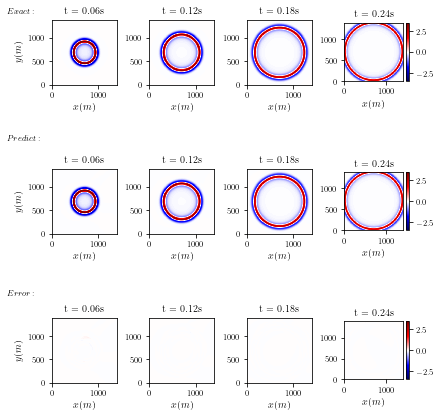

In [9]:
fig, ax = newfig(1.15, 1.7)
ax.axis('off') 
######## Row 2: Pressure #######################
fig.text(0.0, 0.85, '$Exact:$', fontsize = 8)
fig.text(0.0, 0.58, '$Predict:$', fontsize = 8)
fig.text(0.0, 0.25, '$Error:$', fontsize = 8)
########     Exact p(t,x,y)     ########### 
gs2 = gridspec.GridSpec(3, 4)
gs2.update(top=0.9, bottom=0, left=0.1, right=0.9, wspace=0.5, hspace=0.2)

ax = plt.subplot(gs2[0, 0])
h = ax.imshow(UU1_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.06s', fontsize = 10)

ax = plt.subplot(gs2[0, 1])
h = ax.imshow(UU2_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.12s', fontsize = 10)

ax = plt.subplot(gs2[0, 2])
h = ax.imshow(UU3_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.18s', fontsize = 10)

ax = plt.subplot(gs2[0, 3])
h = ax.imshow(UU4_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.24s', fontsize = 10)
########      Predicted p(t,x,y)     ###########

ax = plt.subplot(gs2[1, 0])
h = ax.imshow(UU1_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.06s', fontsize = 10)

ax = plt.subplot(gs2[1, 1])
h = ax.imshow(UU2_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.12s', fontsize = 10)

ax = plt.subplot(gs2[1, 2])
h = ax.imshow(UU3_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.18s', fontsize = 10)

ax = plt.subplot(gs2[1, 3])
h = ax.imshow(UU4_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.24s', fontsize = 10)

#########################Error###############################
ax = plt.subplot(gs2[2, 0])
h = ax.imshow(UU1_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.06s', fontsize = 10)

ax = plt.subplot(gs2[2, 1])
h = ax.imshow(UU2_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.12s', fontsize = 10)

ax = plt.subplot(gs2[2, 2])
h = ax.imshow(UU3_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.18s', fontsize = 10)

ax = plt.subplot(gs2[2, 3])
h = ax.imshow(UU4_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.24s', fontsize = 10)

plt.savefig('./figures/homo/5kdata_1wphy/weq_comparison.png', dpi = 600)

# 局部空间无物理约束

In [6]:
# N_train points for physics constrain as well as boundary constrain
N_u_train = 5000
N_f_train = 10000

# first layer = 3 for (x y t) and the last layer = 1 for (u)
layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# Load FD Data
data = scipy.io.loadmat('./generate_data/weq_300_150.mat')         
U_star = data['u_star'] # N x T
T_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2
vp_star = data['vp_star'] # N x 1
N = X_star.shape[0]
T = T_star.shape[0]

# Rearrange Data 

XX = np.tile(X_star[:,0:1], (1,T)).T # T x N
YY = np.tile(X_star[:,1:2], (1,T)).T # T x N
VP = np.tile(vp_star[:,0:1], (1,T)).T # T x N
TT = np.tile(T_star[:,0:1], (1,N)) # T x N   
UU = U_star.T # T x N

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
vp = VP.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1
u = UU.flatten()[:,None] # NT x 1


######################################################################
######################## Noiseless Data ##############################
######################################################################
X = np.concatenate([x, y, t], 1)       
lb = X.min(0)
ub = X.max(0)

# Training Data randomly selected from N*T dimensional sapce for training   
np.random.seed(1234)
tf.set_random_seed(1234)

#FD simulation data set
idx_u = np.random.choice(N*10, N_u_train, replace=False)
x_u_train = x[idx_u,:]
y_u_train = y[idx_u,:]
t_u_train = t[idx_u,:]
u_train = u[idx_u,:]

# physics constrain from all data set
X_f_train = lb + (ub-lb)*lhs(3, N_f_train)
x_f_train = X_f_train[:,0:1]
y_f_train = X_f_train[:,1:2]
t_f_train = X_f_train[:,2:3]
vp_train = 2500


# #random select physics constrain
# idx_f = np.random.choice(N*T, N_f_train, replace=False)  
# x_f_train = x[idx_f,:]
# y_f_train = y[idx_f,:]
# t_f_train = t[idx_f,:]
# vp_train = vp[idx_f,:]

# Training
niter_bfgs = 10000

train_or_not = 0
history_loss = []

if train_or_not == 1:
    model = PhysicsInformedNN(x_u_train, y_u_train, t_u_train, x_f_train, y_f_train, t_f_train, u_train, vp_train, layers, niter_bfgs)
    # loss_out = model.train(iter=5000, learning_rate=1e-3, batch_num=1, whichloss = 0)
    # history_loss.extend(loss_out)
    # with open('history_loss_adam.txt', 'ab') as f:
    #     np.savetxt(f, history_loss)
    model.train_bfgs(batch_num=1, whichloss = 0)
    
else:   
    model = PhysicsInformedNN(x_u_train, y_u_train, t_u_train, x_f_train, y_f_train, t_f_train, u_train, vp_train, layers, niter_bfgs, ExistModel=1, modelDir='./models/homo/5kdata_small_t/NN_1.pickle')

model.save_NN('./models/homo/5kdata_small_t/NN_1.pickle')

print('Max time step for u training: %e' % (t_u_train.max()))
print('Max time step for f training: %e' % (t_f_train.max()))

# Test Data at snap = 100 (1-200 time steps) compared with predicted data
snap = np.array([30,60,90,120])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star1 = TT.T[:,snap[0:1]]
u_star1 = U_star[:,snap[0:1]]
t_star2 = TT.T[:,snap[1:2]]
u_star2 = U_star[:,snap[1:2]]
t_star3 = TT.T[:,snap[2:3]]
u_star3 = U_star[:,snap[2:3]]
t_star4 = TT.T[:,snap[3:4]]
u_star4 = U_star[:,snap[3:4]]
    
# Prediction
u_pred1 = model.predict(x_star, y_star, t_star1)
u_pred2 = model.predict(x_star, y_star, t_star2)
u_pred3 = model.predict(x_star, y_star, t_star3)
u_pred4 = model.predict(x_star, y_star, t_star4)
lambda_1_value = model.sess.run(model.lambda_1)

    
# Error
error_u = np.linalg.norm(u_star2-u_pred2,2)/np.linalg.norm(u_star2,2)
error_lambda_1 = np.abs(lambda_1_value - 1.0)*100

print('Error u: %e' % (error_u))     
print('Error l1: %.5f%%' % (error_lambda_1))                             


# Plot Results
#    plot_solution(X_star, u_pred, 1)  
#    plot_solution(X_star, u_star, 2)
#    plot_solution(X_star, u_star - u_pred, 3)

# Predict for plotting
lb = X_star.min(0)
ub = X_star.max(0)
nn = 256
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x,y)
UU1_pred = griddata(X_star, u_pred1.flatten(), (X, Y), method='cubic')
UU2_pred = griddata(X_star, u_pred2.flatten(), (X, Y), method='cubic')
UU3_pred = griddata(X_star, u_pred3.flatten(), (X, Y), method='cubic')
UU4_pred = griddata(X_star, u_pred4.flatten(), (X, Y), method='cubic')
UU1_exact = griddata(X_star, u_star1.flatten(), (X, Y), method='cubic')
UU2_exact = griddata(X_star, u_star2.flatten(), (X, Y), method='cubic')
UU3_exact = griddata(X_star, u_star3.flatten(), (X, Y), method='cubic')
UU4_exact = griddata(X_star, u_star4.flatten(), (X, Y), method='cubic')
UU1_differ = UU1_exact - UU1_pred
UU2_differ = UU2_exact - UU2_pred
UU3_differ = UU3_exact - UU3_pred
UU4_differ = UU4_exact - UU4_pred
VP_exact = griddata(X_star, vp_star.flatten(), (X, Y), method='cubic')

Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Save NN parameters successfully...
Max time step for u training: 1.800000e-02
Max time step for f training: 2.979893e-01
Error u: 1.701299e+00
Error l1: 100.00000%


## 速度模型与采样点分布

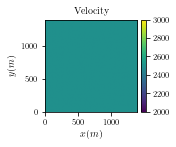

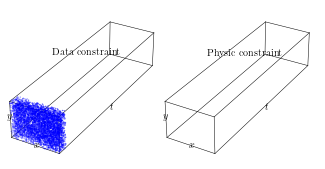

In [10]:
####### Row 0: Velocity ##################    
fig, ax = newfig(1.0, 1.2)
ax.axis('off')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-2/4 + 0.12, left=0.0, right=1.0, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(VP_exact, interpolation='nearest', cmap='viridis', vmin=2000, vmax=3000, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('Velocity', fontsize = 10)
plt.savefig('./figures/homo/5kdata_small_t/Velocity.png', dpi = 600)

####### Row 1: Training data ##################
########      data sets     ###################
fig, ax = newfig(1.0, 0.8)
ax.axis('off')

gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=0.9, bottom=0.0, left=0.1, right=0.9, wspace=0.0)

ax = plt.subplot(gs1[:, 0],  projection='3d')
ax.axis('off')
tscale = 17000 # scaling for t axis
yscale = 1
r1 = [x_star.min(), x_star.max()]
r2 = [tscale*data['t'].min(), tscale*data['t'].max()]       
r3 = [yscale*y_star.min(), yscale*y_star.max()]

for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

ax.scatter(x_u_train, tscale*t_u_train, yscale*y_u_train, s = 0.1, c='b')
#ax.contourf(X,UU2_pred,yscale*Y, zdir = 'y', offset = tscale*t_star2.mean(), cmap='seismic', vmin=-3.5, vmax=3.5, alpha = 0.8)
          
ax.text(x_star.mean()-50, tscale*data['t'].min(), yscale*y_star.min() - 100, '$x$')
ax.text(x_star.max(), tscale*data['t'].mean(), yscale*y_star.min() - 120, '$t$')
ax.text(x_star.min()-100, tscale*data['t'].min(), yscale*y_star.mean(), '$y$')
ax.text(x_star.min(), tscale*data['t'].mean()-600, yscale*y_star.max() + 500, 'Data constraint', fontsize=10.0)    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)


########      physic data sets     ###################        
ax = plt.subplot(gs1[:, 1],  projection='3d')
ax.axis('off')
tscale = 17000 # scaling for t axis
yscale = 1
r1 = [x_star.min(), x_star.max()]
r2 = [tscale*data['t'].min(), tscale*data['t'].max()]       
r3 = [yscale*y_star.min(), yscale*y_star.max()]

for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

#ax.scatter(x_f_train, tscale*t_f_train, yscale*y_f_train, s = 0.1, c='r')
#ax.contourf(X,UU2_exact,yscale*Y, zdir = 'y', offset = tscale*t_star2.mean(), cmap='seismic', vmin=-3.5, vmax=3.5, alpha = 0.8)
          
ax.text(x_star.mean()-50, tscale*data['t'].min(), yscale*y_star.min() - 100, '$x$')
ax.text(x_star.max(), tscale*data['t'].mean(), yscale*y_star.min() - 120, '$t$')
ax.text(x_star.min()-100, tscale*data['t'].min(), yscale*y_star.mean(), '$y$')
ax.text(x_star.min(), tscale*data['t'].mean()-600, yscale*y_star.max() + 500, 'Physic constraint', fontsize=10.0)    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)

plt.savefig('./figures/homo/5kdata_small_t/Training_sets_position.png', dpi = 600)

## 波场值对比

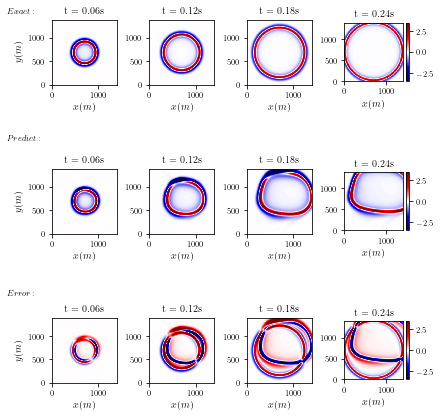

In [11]:
fig, ax = newfig(1.15, 1.7)
ax.axis('off') 
######## Row 2: Pressure #######################
fig.text(0.0, 0.85, '$Exact:$', fontsize = 8)
fig.text(0.0, 0.58, '$Predict:$', fontsize = 8)
fig.text(0.0, 0.25, '$Error:$', fontsize = 8)
########     Exact p(t,x,y)     ########### 
gs2 = gridspec.GridSpec(3, 4)
gs2.update(top=0.9, bottom=0, left=0.1, right=0.9, wspace=0.5, hspace=0.2)

ax = plt.subplot(gs2[0, 0])
h = ax.imshow(UU1_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.06s', fontsize = 10)

ax = plt.subplot(gs2[0, 1])
h = ax.imshow(UU2_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.12s', fontsize = 10)

ax = plt.subplot(gs2[0, 2])
h = ax.imshow(UU3_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.18s', fontsize = 10)

ax = plt.subplot(gs2[0, 3])
h = ax.imshow(UU4_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.24s', fontsize = 10)
########      Predicted p(t,x,y)     ###########

ax = plt.subplot(gs2[1, 0])
h = ax.imshow(UU1_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.06s', fontsize = 10)

ax = plt.subplot(gs2[1, 1])
h = ax.imshow(UU2_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.12s', fontsize = 10)

ax = plt.subplot(gs2[1, 2])
h = ax.imshow(UU3_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.18s', fontsize = 10)

ax = plt.subplot(gs2[1, 3])
h = ax.imshow(UU4_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.24s', fontsize = 10)

#########################Error###############################
ax = plt.subplot(gs2[2, 0])
h = ax.imshow(UU1_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.06s', fontsize = 10)

ax = plt.subplot(gs2[2, 1])
h = ax.imshow(UU2_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.12s', fontsize = 10)

ax = plt.subplot(gs2[2, 2])
h = ax.imshow(UU3_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.18s', fontsize = 10)

ax = plt.subplot(gs2[2, 3])
h = ax.imshow(UU4_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.24s', fontsize = 10)

plt.savefig('./figures/homo/5kdata_small_t/weq_comparison.png', dpi = 600)

# 局部空间有物理约束

In [12]:
# N_train points for physics constrain as well as boundary constrain
N_u_train = 5000
N_f_train = 10000

# first layer = 3 for (x y t) and the last layer = 1 for (u)
layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# Load FD Data
data = scipy.io.loadmat('./generate_data/weq_300_150.mat')         
U_star = data['u_star'] # N x T
T_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2
vp_star = data['vp_star'] # N x 1
N = X_star.shape[0]
T = T_star.shape[0]

# Rearrange Data 

XX = np.tile(X_star[:,0:1], (1,T)).T # T x N
YY = np.tile(X_star[:,1:2], (1,T)).T # T x N
VP = np.tile(vp_star[:,0:1], (1,T)).T # T x N
TT = np.tile(T_star[:,0:1], (1,N)) # T x N   
UU = U_star.T # T x N

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
vp = VP.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1
u = UU.flatten()[:,None] # NT x 1


######################################################################
######################## Noiseless Data ##############################
######################################################################
X = np.concatenate([x, y, t], 1)       
lb = X.min(0)
ub = X.max(0)

# Training Data randomly selected from N*T dimensional sapce for training   
np.random.seed(1234)
tf.set_random_seed(1234)

#FD simulation data set
idx_u = np.random.choice(N*10, N_u_train, replace=False)
x_u_train = x[idx_u,:]
y_u_train = y[idx_u,:]
t_u_train = t[idx_u,:]
u_train = u[idx_u,:]

# physics constrain from all data set
X_f_train = lb + (ub-lb)*lhs(3, N_f_train)
x_f_train = X_f_train[:,0:1]
y_f_train = X_f_train[:,1:2]
t_f_train = X_f_train[:,2:3]
vp_train = 2500


# #random select physics constrain
# idx_f = np.random.choice(N*T, N_f_train, replace=False)  
# x_f_train = x[idx_f,:]
# y_f_train = y[idx_f,:]
# t_f_train = t[idx_f,:]
# vp_train = vp[idx_f,:]

# Training
niter_bfgs = 10000

train_or_not = 0
history_loss = []

if train_or_not == 1:
    model = PhysicsInformedNN(x_u_train, y_u_train, t_u_train, x_f_train, y_f_train, t_f_train, u_train, vp_train, layers, niter_bfgs)
    # loss_out = model.train(iter=5000, learning_rate=1e-3, batch_num=1, whichloss = 0)
    # history_loss.extend(loss_out)
    # with open('history_loss_adam.txt', 'ab') as f:
    #     np.savetxt(f, history_loss)
    model.train_bfgs(batch_num=1, whichloss = 0)
    
else:   
    model = PhysicsInformedNN(x_u_train, y_u_train, t_u_train, x_f_train, y_f_train, t_f_train, u_train, vp_train, layers, niter_bfgs, ExistModel=1, modelDir='./models/homo/5kdata_1wphy_small_t/NN_1.pickle')

model.save_NN('./models/homo/5kdata_1wphy_small_t/NN_1.pickle')

print('Max time step for u training: %e' % (t_u_train.max()))
print('Max time step for f training: %e' % (t_f_train.max()))

# Test Data at snap = 100 (1-200 time steps) compared with predicted data
snap = np.array([30,60,90,120])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star1 = TT.T[:,snap[0:1]]
u_star1 = U_star[:,snap[0:1]]
t_star2 = TT.T[:,snap[1:2]]
u_star2 = U_star[:,snap[1:2]]
t_star3 = TT.T[:,snap[2:3]]
u_star3 = U_star[:,snap[2:3]]
t_star4 = TT.T[:,snap[3:4]]
u_star4 = U_star[:,snap[3:4]]
    
# Prediction
u_pred1 = model.predict(x_star, y_star, t_star1)
u_pred2 = model.predict(x_star, y_star, t_star2)
u_pred3 = model.predict(x_star, y_star, t_star3)
u_pred4 = model.predict(x_star, y_star, t_star4)
lambda_1_value = model.sess.run(model.lambda_1)

    
# Error
error_u = np.linalg.norm(u_star2-u_pred2,2)/np.linalg.norm(u_star2,2)
error_lambda_1 = np.abs(lambda_1_value - 1.0)*100

print('Error u: %e' % (error_u))     
print('Error l1: %.5f%%' % (error_lambda_1))                             


# Plot Results
#    plot_solution(X_star, u_pred, 1)  
#    plot_solution(X_star, u_star, 2)
#    plot_solution(X_star, u_star - u_pred, 3)

# Predict for plotting
lb = X_star.min(0)
ub = X_star.max(0)
nn = 256
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x,y)
UU1_pred = griddata(X_star, u_pred1.flatten(), (X, Y), method='cubic')
UU2_pred = griddata(X_star, u_pred2.flatten(), (X, Y), method='cubic')
UU3_pred = griddata(X_star, u_pred3.flatten(), (X, Y), method='cubic')
UU4_pred = griddata(X_star, u_pred4.flatten(), (X, Y), method='cubic')
UU1_exact = griddata(X_star, u_star1.flatten(), (X, Y), method='cubic')
UU2_exact = griddata(X_star, u_star2.flatten(), (X, Y), method='cubic')
UU3_exact = griddata(X_star, u_star3.flatten(), (X, Y), method='cubic')
UU4_exact = griddata(X_star, u_star4.flatten(), (X, Y), method='cubic')
UU1_differ = UU1_exact - UU1_pred
UU2_differ = UU2_exact - UU2_pred
UU3_differ = UU3_exact - UU3_pred
UU4_differ = UU4_exact - UU4_pred
VP_exact = griddata(X_star, vp_star.flatten(), (X, Y), method='cubic')

Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Save NN parameters successfully...
Max time step for u training: 1.800000e-02
Max time step for f training: 2.979893e-01
Error u: 5.035385e-01
Error l1: 100.00000%


## 速度模型与采样点分布

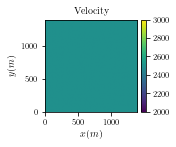

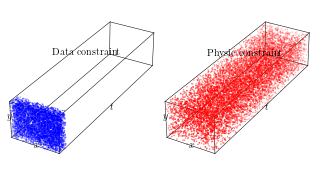

In [9]:
####### Row 0: Velocity ##################    
fig, ax = newfig(1.0, 1.2)
ax.axis('off')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-2/4 + 0.12, left=0.0, right=1.0, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(VP_exact, interpolation='nearest', cmap='viridis', vmin=2000, vmax=3000, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('Velocity', fontsize = 10)
plt.savefig('./figures/homo/5kdata_1wphy_small_t//Velocity.png', dpi = 600)

####### Row 1: Training data ##################
########      data sets     ###################
fig, ax = newfig(1.0, 0.8)
ax.axis('off')

gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=0.9, bottom=0.0, left=0.1, right=0.9, wspace=0.0)

ax = plt.subplot(gs1[:, 0],  projection='3d')
ax.axis('off')
tscale = 17000 # scaling for t axis
yscale = 1
r1 = [x_star.min(), x_star.max()]
r2 = [tscale*data['t'].min(), tscale*data['t'].max()]       
r3 = [yscale*y_star.min(), yscale*y_star.max()]

for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

ax.scatter(x_u_train, tscale*t_u_train, yscale*y_u_train, s = 0.1, c='b')
#ax.contourf(X,UU2_pred,yscale*Y, zdir = 'y', offset = tscale*t_star2.mean(), cmap='seismic', vmin=-3.5, vmax=3.5, alpha = 0.8)
          
ax.text(x_star.mean()-50, tscale*data['t'].min(), yscale*y_star.min() - 100, '$x$')
ax.text(x_star.max(), tscale*data['t'].mean(), yscale*y_star.min() - 120, '$t$')
ax.text(x_star.min()-100, tscale*data['t'].min(), yscale*y_star.mean(), '$y$')
ax.text(x_star.min(), tscale*data['t'].mean()-600, yscale*y_star.max() + 500, 'Data constraint', fontsize=10.0)    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)


########      physic data sets     ###################        
ax = plt.subplot(gs1[:, 1],  projection='3d')
ax.axis('off')
tscale = 17000 # scaling for t axis
yscale = 1
r1 = [x_star.min(), x_star.max()]
r2 = [tscale*data['t'].min(), tscale*data['t'].max()]       
r3 = [yscale*y_star.min(), yscale*y_star.max()]

for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

ax.scatter(x_f_train, tscale*t_f_train, yscale*y_f_train, s = 0.1, c='r')
#ax.contourf(X,UU2_exact,yscale*Y, zdir = 'y', offset = tscale*t_star2.mean(), cmap='seismic', vmin=-3.5, vmax=3.5, alpha = 0.8)
          
ax.text(x_star.mean()-50, tscale*data['t'].min(), yscale*y_star.min() - 100, '$x$')
ax.text(x_star.max(), tscale*data['t'].mean(), yscale*y_star.min() - 120, '$t$')
ax.text(x_star.min()-100, tscale*data['t'].min(), yscale*y_star.mean(), '$y$')
ax.text(x_star.min(), tscale*data['t'].mean()-600, yscale*y_star.max() + 500, 'Physic constraint', fontsize=10.0)    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)

plt.savefig('./figures/homo/5kdata_1wphy_small_t/Training_sets_position.png', dpi = 600)

## 波场值对比

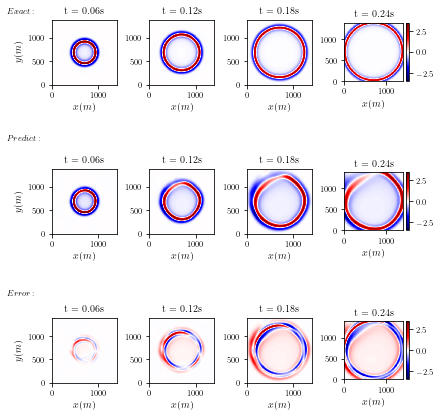

In [13]:
fig, ax = newfig(1.15, 1.7)
ax.axis('off') 
######## Row 2: Pressure #######################
fig.text(0.0, 0.85, '$Exact:$', fontsize = 8)
fig.text(0.0, 0.58, '$Predict:$', fontsize = 8)
fig.text(0.0, 0.25, '$Error:$', fontsize = 8)
########     Exact p(t,x,y)     ########### 
gs2 = gridspec.GridSpec(3, 4)
gs2.update(top=0.9, bottom=0, left=0.1, right=0.9, wspace=0.5, hspace=0.2)

ax = plt.subplot(gs2[0, 0])
h = ax.imshow(UU1_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.06s', fontsize = 10)

ax = plt.subplot(gs2[0, 1])
h = ax.imshow(UU2_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.12s', fontsize = 10)

ax = plt.subplot(gs2[0, 2])
h = ax.imshow(UU3_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.18s', fontsize = 10)

ax = plt.subplot(gs2[0, 3])
h = ax.imshow(UU4_exact, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.24s', fontsize = 10)
########      Predicted p(t,x,y)     ###########

ax = plt.subplot(gs2[1, 0])
h = ax.imshow(UU1_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.06s', fontsize = 10)

ax = plt.subplot(gs2[1, 1])
h = ax.imshow(UU2_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.12s', fontsize = 10)

ax = plt.subplot(gs2[1, 2])
h = ax.imshow(UU3_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.18s', fontsize = 10)

ax = plt.subplot(gs2[1, 3])
h = ax.imshow(UU4_pred, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.24s', fontsize = 10)

#########################Error###############################
ax = plt.subplot(gs2[2, 0])
h = ax.imshow(UU1_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
ax.set_ylabel('$y(m)$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.06s', fontsize = 10)

ax = plt.subplot(gs2[2, 1])
h = ax.imshow(UU2_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.12s', fontsize = 10)

ax = plt.subplot(gs2[2, 2])
h = ax.imshow(UU3_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.18s', fontsize = 10)

ax = plt.subplot(gs2[2, 3])
h = ax.imshow(UU4_differ, interpolation='nearest', cmap='seismic', vmin=-3.5, vmax=3.5, 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x(m)$')
#ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('t = 0.24s', fontsize = 10)

plt.savefig('./figures/homo/5kdata_1wphy_small_t/weq_comparison.png', dpi = 600)